# LLM Inference 이해하기: 토큰 예측의 마법

## 개요
이 노트북에서는 대규모 언어 모델(LLM)의 **Inference(추론)** 과정을 실습을 통해 이해합니다. LLM이 어떻게 텍스트를 생성하는지, 그 내부 메커니즘을 시각화하여 살펴봅니다.

## 학습 목표
- ✅ LLM Inference의 기본 개념 이해
- ✅ 토큰 단위 예측과 Auto-regressive Generation 이해
- ✅ TokenPredictor를 활용한 실제 추론 과정 시각화
- ✅ 확률 분포와 토큰 선택 메커니즘 파악

## 1. LLM Inference란?

**Inference(추론)** 는 학습된 모델을 사용하여 새로운 입력에 대한 예측을 수행하는 과정입니다.

### Training vs Inference

| 구분 | Training (학습) | Inference (추론) |
|------|----------------|------------------|
| **목적** | 모델 파라미터 최적화 | 학습된 모델로 예측 수행 |
| **방향** | Forward + Backward pass | Forward pass만 |
| **데이터** | 대량의 학습 데이터 필요 | 단일 입력으로 실행 가능 |
| **시간** | 수일~수개월 소요 | 밀리초~수초 단위 |
| **리소스** | GPU 클러스터 필요 | 단일 GPU 또는 CPU 가능 |

### LLM의 Inference 특징
- **Auto-regressive**: 이전에 생성한 토큰을 기반으로 다음 토큰을 예측
- **토큰 단위 생성**: 한 번에 하나의 토큰씩 순차적으로 생성
- **확률적 선택**: 각 토큰에 대한 확률 분포를 계산하고 샘플링

## 2. Auto-regressive Generation 프로세스

LLM이 텍스트를 생성하는 과정은 다음과 같습니다:

```
1. 입력 텍스트 → 토큰화
   "Hello, how are" → [15496, 11, 1268, 527]

2. 모델에 입력하여 다음 토큰 확률 분포 계산
   → { "you": 0.85, "your": 0.10, "things": 0.03, ... }

3. 확률 분포에서 토큰 선택 (sampling)
   → "you" 선택

4. 선택된 토큰을 입력에 추가
   "Hello, how are you"

5. 종료 조건까지 2-4 반복
   (max_tokens, EOS 토큰 등)
```

### 주요 생성 전략
- **Greedy Decoding**: 매번 가장 높은 확률의 토큰 선택
- **Sampling**: 확률 분포에 따라 랜덤하게 선택
- **Top-k Sampling**: 상위 k개 토큰 중에서 선택
- **Temperature**: 확률 분포의 날카로움 조절

## 3. 실습: TokenPredictor로 Inference 시각화

이제 실제 LLM의 토큰 예측 과정을 시각화해봅시다. `TokenPredictor`는 모델이 각 단계에서 어떤 토큰을 얼마나 높은 확률로 예측하는지 보여줍니다.

In [1]:
# 필요한 라이브러리 임포트
from visualizer import TokenPredictor, create_token_graph, visualize_predictions
import matplotlib.pyplot as plt

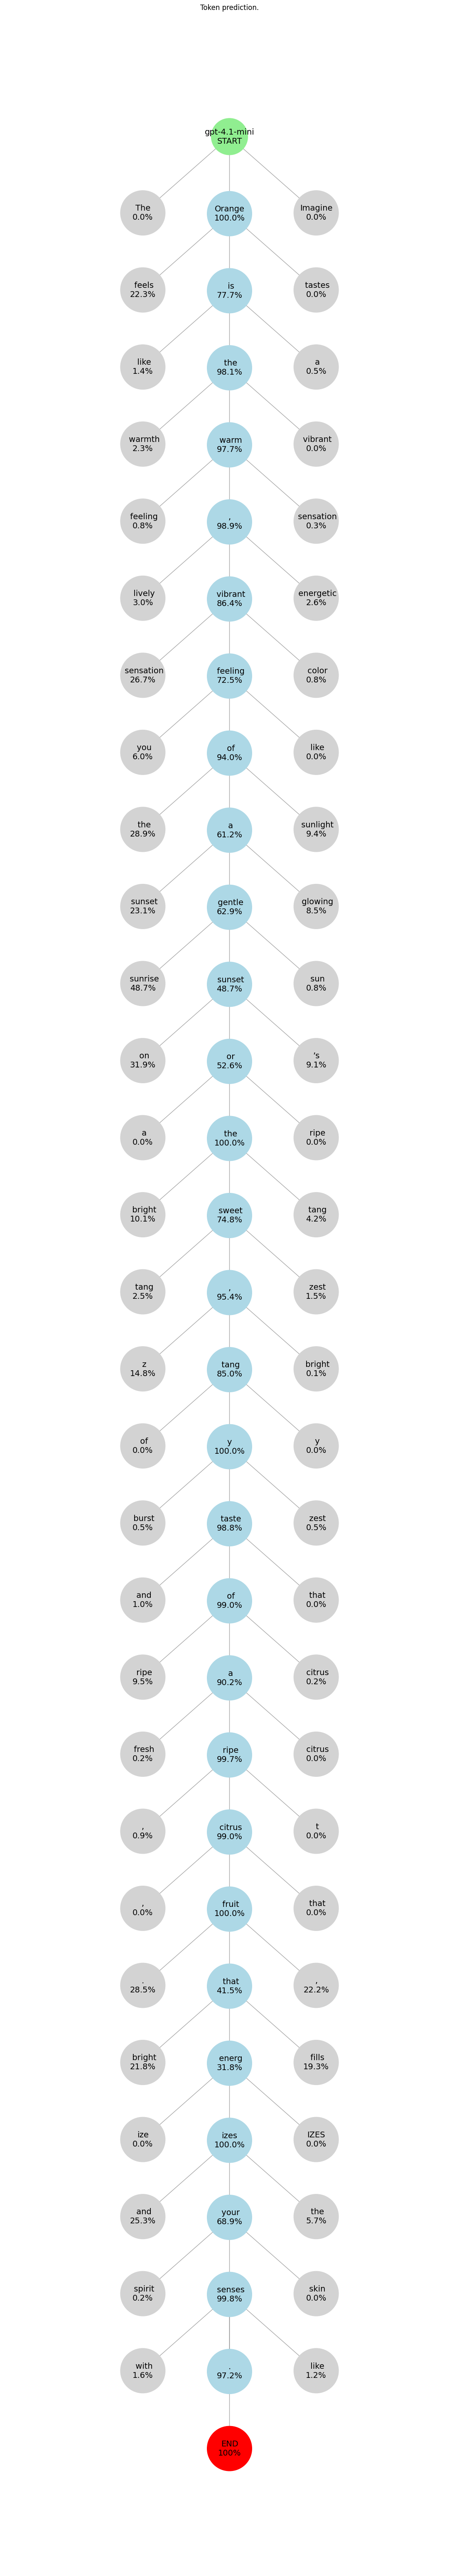


=== 생성된 응답 ===
Orange is the warm, vibrant feeling of a gentle sunset or the sweet, tangy taste of a ripe citrus fruit that energizes your senses.


In [2]:
# 예제 1: 색상 "orange" 설명하기

# 입력 프롬프트 정의
message = "In one sentence, describe the color orange to someone who has never been able to see"

# 사용할 모델 지정 (GPT-4.1-mini)
model_name = "gpt-4.1-mini"

# TokenPredictor 인스턴스 생성
# 이 객체는 모델의 inference 과정을 추적합니다
predictor = TokenPredictor(model_name)

# 실제 inference 실행
# predictions: 각 단계에서 예측된 토큰과 확률 정보
predictions = predictor.predict_tokens(message)

# 토큰 예측 그래프 생성
# 각 노드는 생성된 토큰, 엣지는 예측 확률을 나타냄
G = create_token_graph(model_name, predictions)

# 시각화 실행
plt = visualize_predictions(G)
plt.show()

# 생성된 결과 출력
print("\n=== 생성된 응답 ===")
print("".join([p['token'] for p in predictions]))

## 4. 결과 분석

위 시각화에서 볼 수 있는 것들:

### 그래프 구조
- **노드(Node)**: 각 단계에서 생성된 토큰
- **엣지(Edge)**: 이전 토큰에서 다음 토큰으로의 전이
- **엣지 가중치**: 해당 토큰이 선택될 확률 (0~1)

### Inference 과정의 특징

1. **순차적 생성**: 왼쪽에서 오른쪽으로 한 토큰씩 생성
2. **컨텍스트 의존성**: 이전 모든 토큰이 다음 토큰 예측에 영향
3. **확률적 선택**: 매 단계마다 확률 분포에서 토큰 샘플링
4. **종료 조건**: 특정 토큰(EOS)이나 최대 길이 도달 시 종료

### 핵심 통찰
- 모델은 **수천~수만 개의 토큰 후보** 중에서 선택
- 높은 확률 = 모델이 해당 토큰이 적합하다고 확신
- 낮은 확률 토큰도 선택 가능 (sampling 전략에 따라)

## 5. 다양한 프롬프트로 Inference 패턴 비교

이제 다른 유형의 프롬프트로 모델의 inference 패턴이 어떻게 달라지는지 살펴봅시다.

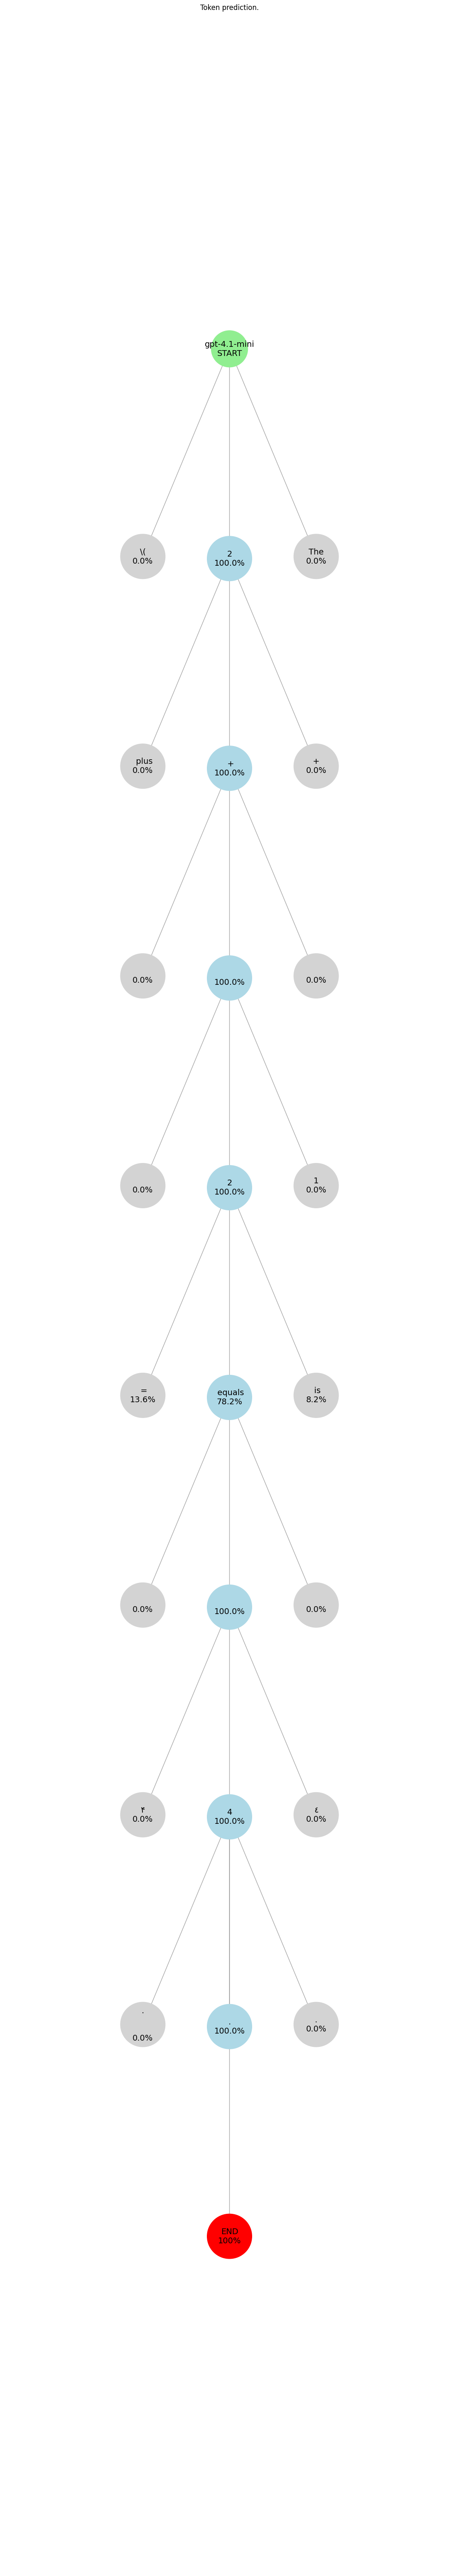


=== 수학 문제 응답 ===
2 + 2 equals 4.


In [3]:
# 예제 2: 수학 문제 - 높은 확실성 예상

message_math = "What is 2 + 2?"
predictor_math = TokenPredictor(model_name)
predictions_math = predictor_math.predict_tokens(message_math)

G_math = create_token_graph(model_name, predictions_math)
plt_math = visualize_predictions(G_math)
plt_math.show()

print("\n=== 수학 문제 응답 ===")
print("".join([p['token'] for p in predictions_math]))

/Users/windfree/workspace/ws.study/ai-engineering/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


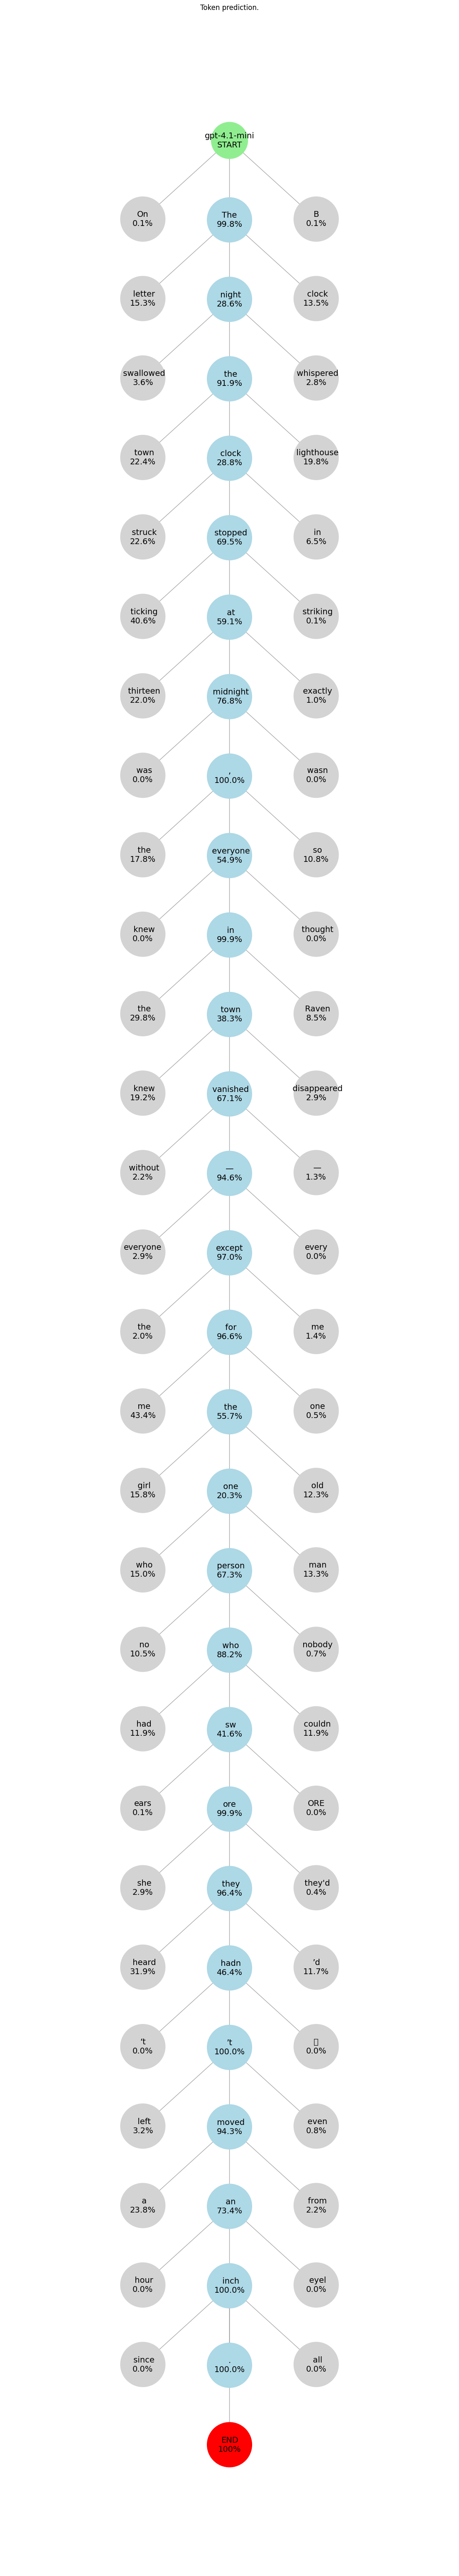


=== 창의적 글쓰기 응답 ===
The night the clock stopped at midnight, everyone in town vanished—except for the one person who swore they hadn’t moved an inch.


In [4]:
# 예제 3: 창의적 글쓰기 - 다양한 가능성

message_creative = "Write a creative opening line for a mystery novel"
predictor_creative = TokenPredictor(model_name)
predictions_creative = predictor_creative.predict_tokens(message_creative)

G_creative = create_token_graph(model_name, predictions_creative)
plt_creative = visualize_predictions(G_creative)
plt_creative.show()

print("\n=== 창의적 글쓰기 응답 ===")
print("".join([p['token'] for p in predictions_creative]))

### 예제 비교 분석

위 세 가지 예제를 비교해보면:

| 특징 | 수학 문제 | 색상 설명 | 창의적 글쓰기 |
|------|----------|----------|--------------|
| **확률 분포** | 매우 집중됨 | 중간 | 분산됨 |
| **예측 확실성** | 높음 (정답이 명확) | 중간 | 낮음 (창의성 필요) |
| **토큰 다양성** | 낮음 | 중간 | 높음 |

이는 **모델이 문제 유형에 따라 다른 확신도**를 가진다는 것을 보여줍니다:
- 사실적/수학적 질문: 높은 확률로 특정 토큰 선택
- 창의적/개방형 질문: 여러 토큰이 비슷한 확률 가짐

## 6. Inference 최적화 기법

실제 프로덕션 환경에서는 inference 속도와 효율성이 중요합니다.

### 주요 최적화 방법

1. **배치 처리 (Batching)**
   - 여러 입력을 동시에 처리하여 GPU 활용도 향상
   - Throughput 증가, 단 latency는 약간 증가 가능

2. **모델 양자화 (Quantization)**
   - FP32 → FP16, INT8로 정밀도 낮추기
   - 메모리 사용량 감소, 속도 향상
   - 예: `torch.quantization`, `bitsandbytes`

3. **KV-Cache**
   - 이전 토큰의 Key-Value를 캐싱
   - 중복 계산 제거, 속도 2-3배 향상

4. **투기적 디코딩 (Speculative Decoding)**
   - 작은 모델로 여러 토큰 예측 → 큰 모델로 검증
   - 레이턴시 감소

### Inference 성능 지표

```python
# 주요 측정 항목
- Latency: 첫 토큰까지의 시간 (Time to First Token, TTFT)
- Throughput: 초당 생성 토큰 수 (Tokens per second)
- Memory: GPU VRAM 사용량
- Cost: API 호출 시 비용
```

## 7. 결론 및 요약

### 핵심 정리

1. **LLM Inference는 Auto-regressive 프로세스**
   - 한 번에 하나의 토큰씩 순차적으로 생성
   - 이전 모든 토큰이 다음 토큰 예측에 영향

2. **확률 분포 기반 생성**
   - 모델은 각 단계에서 수만 개 토큰의 확률 계산
   - Sampling 전략에 따라 토큰 선택 방식 변경 가능

3. **문제 유형에 따른 확신도 차이**
   - 사실적 질문: 높은 확률로 특정 답변
   - 창의적 질문: 분산된 확률 분포

4. **Training vs Inference**
   - Training: 파라미터 학습 (무거움)
   - Inference: 예측 수행 (가벼움, forward pass만)

### 다음 학습 방향

- ✅ **Tokenization 깊이 이해**: BPE, WordPiece 등
- ✅ **Sampling 전략 실습**: Temperature, Top-k, Top-p
- ✅ **Inference 최적화**: Quantization, KV-Cache 구현
- ✅ **프롬프트 엔지니어링**: 더 나은 응답을 위한 프롬프트 설계
- ✅ **로컬 LLM 서빙**: vLLM, TGI 등 프레임워크 활용

### 참고 자료

- [Hugging Face Transformers Documentation](https://huggingface.co/docs/transformers)
- [The Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)
- [Inference Optimization Guide](https://huggingface.co/docs/transformers/llm_tutorial_optimization)

In [ ]:
# 추가 실습: Temperature 변화에 따른 생성 차이 (선택사항)
# TokenPredictor가 temperature 파라미터를 지원한다면 실험해보세요!

# 예시 (실제 구현에 따라 달라질 수 있음):
# predictor_low_temp = TokenPredictor(model_name, temperature=0.2)  # 보수적
# predictor_high_temp = TokenPredictor(model_name, temperature=1.5)  # 창의적

print("🎉 LLM Inference 학습 완료!")